In [69]:
import torch
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

In [70]:
13*13*128*2

43264

In [71]:
class AlexNet(nn.Module):
    def __init__(self, in_channels=3, num_classes=1000):
        super(AlexNet, self).__init__()
        # input 227x227x3
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.conv1 = ConvLayer(in_channels, 48, kernel_size=11, stride=4) # 55x55x48

        self.conv2_1 = ConvLayer(48, 128, True, kernel_size=5, padding=2) # 55x55x128
        self.conv2_2 = ConvLayer(48, 128, True, kernel_size=5, padding=2)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2) # 55x55x128 -> 27x27x128

        self.conv3_1 = ConvLayer(128, 192, True, kernel_size=3, padding=1) # 27x27x192
        self.conv3_2 = ConvLayer(128, 192, True, kernel_size=3, padding=1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2) # 27x27x192 -> 13x13x192

        self.conv4_1 = ConvLayer(192*2, 192, kernel_size=3, padding=1) # 13x13x192
        self.conv4_2 = ConvLayer(192*2, 192, kernel_size=3, padding=1)
        
        self.conv5_1 = ConvLayer(192, 192, kernel_size=3, padding=1) # 13x13x192
        self.conv5_2 = ConvLayer(192, 192, kernel_size=3, padding=1)

        self.conv6_1 = ConvLayer(192, 128, kernel_size=3, padding=1) # 13x13x128
        self.conv6_2 = ConvLayer(192, 128, kernel_size=3, padding=1)

        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2) # 6x6x128

        self.fc_layer1_1 = nn.Sequential(
            nn.Linear(128*6*6, 2048),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(2048, 2048),
            nn.ReLU(True),
            nn.Dropout(0.5),
        )

        self.fc_layer1_2 = nn.Sequential(
            nn.Linear(128*6*6, 2048),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(2048, 2048),
            nn.ReLU(True),
            nn.Dropout(0.5),
        )

        self.fc_layer2 = nn.Sequential(
            nn.Linear(2048*2, num_classes)
        )

    def forward(self, x):
        x = self.conv1(x)

        x1 = self.conv2_1(x)
        x2 = self.conv2_2(x)

        x1 = self.maxpool1(x1)
        x2 = self.maxpool1(x2)

        x1 = self.conv3_1(x1)
        x2 = self.conv3_2(x2)

        x1 = self.maxpool2(x1)
        x2 = self.maxpool2(x2)

        x = torch.cat([x1, x2], 1)

        x1 = self.conv4_1(x)
        x2 = self.conv4_2(x)
        
        x1 = self.conv5_1(x1)
        x2 = self.conv5_2(x2)

        x1 = self.conv6_1(x1)
        x2 = self.conv6_2(x2)

        x1 = self.maxpool2(x1)
        x2 = self.maxpool2(x2)

        x1 = x1.view(x1.size(0), -1)
        x2 = x2.view(x2.size(0), -1)

        x1 = self.fc_layer1_1(x1)
        x2 = self.fc_layer1_2(x2)
        
        x = torch.cat([x1, x2], -1)
        x = self.fc_layer2(x)
        return x

In [72]:
class ConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, lrn=False, **kwargs):
        super(ConvLayer, self).__init__()
        self.lrn = lrn
        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, **kwargs)
        self.LRN = nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2)
        self.relu = nn.ReLU(True)

    def forward(self, x):
        if self.lrn:
            return self.LRN(self.relu(self.conv(x)))
        return self.relu(self.conv(x))

In [73]:
num_classes = 10
batch_size = 64
epochs = 5

learning_rate = 0.001
momentum = 0.9
weight_decay = 0.0005

In [74]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(42)
if DEVICE == 'cuda':
    torch.cuda.manual_seed_all(42)

In [75]:
model = AlexNet(num_classes=num_classes)
model.to(DEVICE)

AlexNet(
  (conv1): ConvLayer(
    (conv): Conv2d(3, 48, kernel_size=(11, 11), stride=(4, 4))
    (LRN): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
    (relu): ReLU(inplace=True)
  )
  (conv2_1): ConvLayer(
    (conv): Conv2d(48, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (LRN): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
    (relu): ReLU(inplace=True)
  )
  (conv2_2): ConvLayer(
    (conv): Conv2d(48, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (LRN): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
    (relu): ReLU(inplace=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3_1): ConvLayer(
    (conv): Conv2d(128, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (LRN): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
    (relu): ReLU(inplace=True)
  )
  (conv3_2): ConvLayer(
    (conv): Conv2d(128, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (LRN): Loca

In [76]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

In [77]:
transform = transforms.Compose(
    [transforms.Resize((256, 256)),
     transforms.RandomHorizontalFlip(p=1),
     transforms.RandomCrop((227, 227)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

In [78]:
trainset = torchvision.datasets.CIFAR10(
    root='data', train=True,
    transform=transform, download=True,
)

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, 
    shuffle=True, drop_last=True
)

testset = torchvision.datasets.CIFAR10(
    root='data', train=False,
    transform=transform, download=True,
)

testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, 
    shuffle=False
)

Files already downloaded and verified
Files already downloaded and verified


In [79]:
loss_values = []

for epoch in range(epochs): 
    avg_loss = 0
    total_batch = len(trainloader)

    for X, Y in trainloader:
        X, Y = X.to(DEVICE), Y.to(DEVICE)
        # X shape (batch_size, channels, width, height)

        optimizer.zero_grad()
        pred = model(X)
        loss = criterion(pred, Y)
        loss.backward()
        optimizer.step()

        avg_loss += loss / total_batch

    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_loss))
    loss_values.append(avg_loss)

print('Learning finished')

Epoch: 0001 cost = 2.302741051
Epoch: 0002 cost = 2.302679300
Epoch: 0003 cost = 2.302638054
Epoch: 0004 cost = 2.302659512
Epoch: 0005 cost = 2.302660942
Learning finished


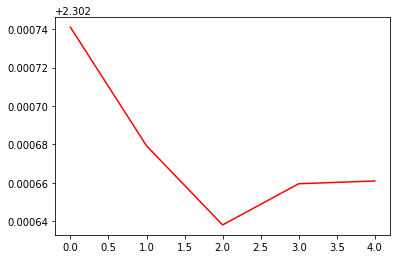

In [80]:
plt.plot(np.array(loss_values),'r')

In [81]:
correct = 0.0
total = 0.0

with torch.no_grad():
    for X, Y in testloader:
        X, Y = X.to(DEVICE), Y.to(DEVICE)
        pred = model(X)

        _, predicted = torch.max(pred.data, 1)

        total += Y.size(0)
        correct += (predicted == Y).sum().item()

print('Acc : %d %%' % ( 100 * correct / total))

Acc : 10 %
